In [26]:
from os.path import join,exists,realpath,dirname,basename
from os import makedirs,listdir, system
import numpy as np, _pickle as cPickle, editdistance, seaborn as sns
import matplotlib.pyplot as plt, pandas as pd, itertools, glob, h5py
from scipy.stats import entropy
from matplotlib.font_manager import FontProperties
from IPython.display import display
from collections import defaultdict
from IPython.display import display
from scipy.stats import ranksums
import multiprocessing as mp
from PIL import Image
sns.set_style("whitegrid")
%matplotlib inline



In [2]:
import gzip
import os

GPUID = 1
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)

from scipy import ndimage
from six.moves import urllib
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import math
import sys
import scipy.io


import pdb


In [3]:

def CNN(inputs, _is_training=True):
    x   = tf.reshape(inputs, [-1, 28, 28, 1])
    batch_norm_params = {'is_training': _is_training, 'decay': 0.9, 'updates_collections': None}
    net = slim.conv2d(x, 32, [5, 5], padding='SAME'
                     , activation_fn       = tf.nn.relu
                     , weights_initializer = tf.truncated_normal_initializer(stddev=0.01)
                     , normalizer_fn       = slim.batch_norm
                     , normalizer_params   = batch_norm_params
                     , scope='conv1')
    net = slim.max_pool2d(net, [2, 2], scope='pool1')
    net = slim.conv2d(net, 64, [5, 5], scope='conv2')
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    net = slim.flatten(net, scope='flatten3')
    net = slim.fully_connected(net, 1024
                    , activation_fn       = tf.nn.relu
                    , weights_initializer = tf.truncated_normal_initializer(stddev=0.01)
                    , normalizer_fn       = slim.batch_norm
                    , normalizer_params   = batch_norm_params
                    , scope='fc4')
    net = slim.dropout(net, keep_prob=0.7, is_training=_is_training, scope='dropout4')  
    out = slim.fully_connected(net, 10, activation_fn=None, normalizer_fn=None, scope='fco')
    return out


# DATA URL
SOURCE_URL      = 'http://yann.lecun.com/exdb/mnist/'
DATA_DIRECTORY  = "data"
# PARAMETERS FOR MNIST
IMAGE_SIZE      = 28
NUM_CHANNELS    = 1
PIXEL_DEPTH     = 255
NUM_LABELS      = 10
VALIDATION_SIZE = 5000  # Size of the validation set.

# DOWNLOAD MNIST DATA, IF NECESSARY
def maybe_download(filename):
    if not tf.gfile.Exists(DATA_DIRECTORY):
        tf.gfile.MakeDirs(DATA_DIRECTORY)
    filepath = os.path.join(DATA_DIRECTORY, filename)
    if not tf.gfile.Exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        with tf.gfile.GFile(filepath) as f:
            size = f.size()
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

# EXTRACT IMAGES
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH # -0.5~0.5
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        data = np.reshape(data, [num_images, -1])
    return data # [image index, y, x, channels]

# EXTRACT LABELS
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        num_labels_data = len(labels)
        one_hot_encoding = np.zeros((num_labels_data,NUM_LABELS))
        one_hot_encoding[np.arange(num_labels_data),labels] = 1
        one_hot_encoding = np.reshape(one_hot_encoding, [-1, NUM_LABELS])
    return one_hot_encoding

# AUGMENT TRAINING DATA
def expend_training_data(images, labels):
    expanded_images = []
    expanded_labels = []
    j = 0 # counter
    for x, y in zip(images, labels):
        j = j+1
        # APPEND ORIGINAL DATA
        expanded_images.append(x)
        expanded_labels.append(y)
        # ASSUME MEDIAN COLOR TO BE BACKGROUND COLOR
        bg_value = np.median(x) # this is regarded as background's value        
        image = np.reshape(x, (-1, 28))

        for i in range(4):
            # ROTATE IMAGE
            angle = np.random.randint(-15,15,1)
            new_img = ndimage.rotate(image,angle,reshape=False, cval=bg_value)
            # SHIFT IAMGE
            shift = np.random.randint(-2, 2, 2)
            new_img_ = ndimage.shift(new_img,shift, cval=bg_value)
            # ADD TO THE LIST
            expanded_images.append(np.reshape(new_img_, 784))
            expanded_labels.append(y)
    expanded_train_total_data = np.concatenate((expanded_images, expanded_labels), axis=1)
    np.random.shuffle(expanded_train_total_data)
    return expanded_train_total_data

# PREPARE MNIST DATA
def prepare_MNIST_data(use_data_augmentation=True):
    # Get the data.
    train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
    train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
    test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
    test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')
    train_data = extract_data(train_data_filename, 60000)
    print(train_data[0])
    train_labels = extract_labels(train_labels_filename, 60000)
    test_data = extract_data(test_data_filename, 10000)
    test_labels = extract_labels(test_labels_filename, 10000)
    validation_data = train_data[:VALIDATION_SIZE, :]
    validation_labels = train_labels[:VALIDATION_SIZE,:]
    train_data = train_data[VALIDATION_SIZE:, :]
    train_labels = train_labels[VALIDATION_SIZE:,:]
    if use_data_augmentation:
        train_total_data = expend_training_data(train_data, train_labels)
    else:
        train_total_data = np.concatenate((train_data, train_labels), axis=1)
    train_size = train_total_data.shape[0]
    return train_total_data, train_size, validation_data, validation_labels, test_data, test_labels

In [4]:

# CONFIGURATION
MODEL_DIRECTORY   = "model/model.ckpt"
LOGS_DIRECTORY    = "logs/train"
training_epochs   = 10
TRAIN_BATCH_SIZE  = 50
display_step      = 500
validation_step   = 500
TEST_BATCH_SIZE   = 5000    


# PREPARE MNIST DATA
batch_size = TRAIN_BATCH_SIZE # BATCH SIZE (50)
num_labels = NUM_LABELS       # NUMBER OF LABELS (10)
train_total_data, train_size, validation_data, validation_labels \
    , test_data, test_labels = prepare_MNIST_data(False)
# PRINT FUNCTION
def print_np(x, str):
    print (" TYPE AND SHAPE OF [%18s ] ARE %s and %14s" 
           % (str, type(x), x.shape,))
print_np(train_total_data, 'train_total_data')
print_np(validation_data, 'validation_data')
print_np(validation_labels, 'validation_labels')
print_np(test_data, 'test_data')
print_np(test_labels, 'test_labels')
################################################################################



# DEFINE MODEL
# PLACEHOLDERS
x  = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10]) #answer
is_training = tf.placeholder(tf.bool, name='MODE')
# CONVOLUTIONAL NEURAL NETWORK MODEL 
y = CNN(x, is_training)
# DEFINE LOSS
with tf.name_scope("LOSS"):
    loss = slim.losses.softmax_cross_entropy(y, y_)
# DEFINE ACCURACY
with tf.name_scope("ACC"):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()


[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5     

 TYPE AND SHAPE OF [  train_total_data ] ARE <class 'numpy.ndarray'> and   (55000, 794)
 TYPE AND SHAPE OF [   validation_data ] ARE <class 'numpy.ndarray'> and    (5000, 784)
 TYPE AND SHAPE OF [ validation_labels ] ARE <class 'numpy.ndarray'> and     (5000, 10)
 TYPE AND SHAPE OF [         test_data ] ARE <class 'numpy.ndarray'> and   (10000, 784)
 TYPE AND SHAPE OF [       test_labels ] ARE <class 'numpy.ndarray'> and    (10000, 10)
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.


In [5]:

# OPEN SESSION
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer(), feed_dict={is_training: False})


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / np.expand_dims(e_x.sum(axis=1), axis=1)   # only difference

# RESTORE SAVED NETWORK
saver.restore(sess, MODEL_DIRECTORY)

INFO:tensorflow:Restoring parameters from model/model.ckpt


In [10]:
np.min(sample)

18

In [52]:
# folders for generated images
rundir = '../log_gan'
preds = []
for i in range(100):
#     print(i)
    datafile = join(rundir, 'epoch_{}.pkl'.format(i))
    if not exists(datafile):
        break
    with open(datafile, 'rb') as f:
        sample = cPickle.load(f)
#     print(sample.reshape(100,784).shape)
    y_final = sess.run(y, feed_dict={x: sample.reshape(100,784)/255-0.5, is_training: False})
    pred_softmax = softmax(y_final)
#     print(pred_softmax)
    preds.append(pred_softmax)

In [53]:
preds = np.concatenate(preds, 0)

In [54]:
preds.shape
gan_scores = []
splits = 100
for i in range(splits):
    part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
    kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
    kl = np.mean(np.sum(kl, 1))
    gan_scores.append(np.exp(kl))

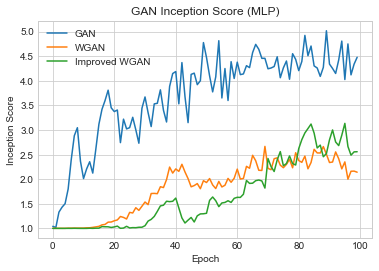

In [55]:
import matplotlib.pyplot as plt
plt.plot(gan_scores,label='GAN')
plt.plot(wgan_scores,label='WGAN')
plt.plot(improved_wgan_scores,label='Improved WGAN')
plt.title("GAN Inception Score (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Inception Score")
plt.legend()
plt.show()


In [40]:
from os.path import join,exists,realpath,dirname,basename
import numpy as np, _pickle as cPickle, editdistance, seaborn as sns
rundir = '../log_improved_wgan_mlp'
samples = []
for i in range(100):
#     print(i)
    scorefile = join(rundir, 'epoch_{}.score'.format(i))
    if not exists(scorefile):   
        datafile = join(rundir, 'epoch_{}.pkl'.format(i))
        if not exists(datafile):
            break
        with open(datafile, 'rb') as f:
            sample = cPickle.load(f)
            samples.append(sample)
samples = np.array(samples)

In [41]:
subsamples = samples[:,:9,:,:] / 255

In [42]:
import matplotlib.pyplot as plt
r, c = 3, 3

fig, axs = plt.subplots(r, c)

eps = [0,49,99]
for ep in eps:
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(subsamples[ep,cnt,:,:], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("improved_wgan_mlp_%d.png" % ep)
    plt.close()